# Comet MLfrom comet_ml import Experiment

In [ ]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [ ]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [ ]:
# experiment.log_parameters(hyper_params)

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [4]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id_x)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [6]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-2.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)
data_val = BoneAgeDataset("boneage-validation-2.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
# val_size = int(len(data_train) * 0.2)
# train_size = len(data_train) - (val_size)

# train_set, val_set = random_split(
#     data_train,
#     [train_size, val_size]
# )

trainloader = DataLoader(data_train, batch_size=bs)
valloader = DataLoader(data_val, batch_size=bs)

In [7]:
len(data_train), len(data_val)

(9996, 2502)

# Architecture and Config

In [8]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [9]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [10]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [11]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [12]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [13]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [14]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [15]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [17]:
!mkdir Model-2

In [18]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Model-2/RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [19]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/157 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 40/40 [00:09<00:00,  4.08it/s, Epoch=1, LR=6.13e-5, Valid_Loss=23.7]


Valid RMSE: 23.769861221313477
Valid MAE: 19.191749572753906
Valid SMAPE: 0.18142463266849518
Validation Loss Improved (inf ---> 23.769861221313477)



100%|██████████| 40/40 [00:08<00:00,  4.71it/s, Epoch=2, LR=5.71e-6, Valid_Loss=29.7]


Valid RMSE: 30.057613372802734
Valid MAE: 19.672624588012695
Valid SMAPE: 0.18507020175457



100%|██████████| 40/40 [00:08<00:00,  4.82it/s, Epoch=3, LR=2.02e-5, Valid_Loss=17.9]


Valid RMSE: 18.07617950439453
Valid MAE: 13.690397262573242
Valid SMAPE: 0.1223013624548912
Validation Loss Improved (23.769861221313477 ---> 18.07617950439453)



100%|██████████| 40/40 [00:08<00:00,  4.77it/s, Epoch=4, LR=8.21e-5, Valid_Loss=22.7]


Valid RMSE: 22.86393165588379
Valid MAE: 16.509849548339844
Valid SMAPE: 0.14738981425762177



100%|██████████| 40/40 [00:09<00:00,  4.04it/s, Epoch=5, LR=9.46e-5, Valid_Loss=20.3]


Valid RMSE: 20.372432708740234
Valid MAE: 16.141613006591797
Valid SMAPE: 0.14408783614635468



100%|██████████| 40/40 [00:08<00:00,  4.80it/s, Epoch=6, LR=3.82e-5, Valid_Loss=14.7]


Valid RMSE: 14.792969703674316
Valid MAE: 11.664361953735352
Valid SMAPE: 0.10418622940778732
Validation Loss Improved (18.07617950439453 ---> 14.792969703674316)



100%|██████████| 40/40 [00:08<00:00,  4.75it/s, Epoch=7, LR=1.02e-6, Valid_Loss=14.8]


Valid RMSE: 14.823867797851562
Valid MAE: 11.723509788513184
Valid SMAPE: 0.10558994114398956



100%|██████████| 40/40 [00:08<00:00,  4.73it/s, Epoch=8, LR=4.12e-5, Valid_Loss=16.4]


Valid RMSE: 16.459800720214844
Valid MAE: 12.656203269958496
Valid SMAPE: 0.11408410966396332



100%|██████████| 40/40 [00:08<00:00,  4.70it/s, Epoch=9, LR=9.59e-5, Valid_Loss=16.5]


Valid RMSE: 16.586450576782227
Valid MAE: 12.47775650024414
Valid SMAPE: 0.11199206113815308



100%|██████████| 40/40 [00:09<00:00,  4.01it/s, Epoch=10, LR=7.96e-5, Valid_Loss=16.6]


Valid RMSE: 16.69164276123047
Valid MAE: 13.043293952941895
Valid SMAPE: 0.12389036267995834



100%|██████████| 40/40 [00:08<00:00,  4.83it/s, Epoch=11, LR=1.78e-5, Valid_Loss=14.1]


Valid RMSE: 14.131413459777832
Valid MAE: 11.171588897705078
Valid SMAPE: 0.10218823701143265
Validation Loss Improved (14.792969703674316 ---> 14.131413459777832)



100%|██████████| 40/40 [00:08<00:00,  4.75it/s, Epoch=12, LR=7.12e-6, Valid_Loss=14.6]


Valid RMSE: 14.656462669372559
Valid MAE: 11.514074325561523
Valid SMAPE: 0.10331156104803085



100%|██████████| 40/40 [00:11<00:00,  3.46it/s, Epoch=13, LR=6.43e-5, Valid_Loss=14.2]


Valid RMSE: 14.298368453979492
Valid MAE: 11.155436515808105
Valid SMAPE: 0.10105931013822556



100%|██████████| 40/40 [00:08<00:00,  4.70it/s, Epoch=14, LR=9.99e-5, Valid_Loss=15.2]


Valid RMSE: 15.255966186523438
Valid MAE: 11.935323715209961
Valid SMAPE: 0.1086714118719101



100%|██████████| 40/40 [00:08<00:00,  4.69it/s, Epoch=15, LR=5.82e-5, Valid_Loss=14.1]


Valid RMSE: 14.122328758239746
Valid MAE: 11.094837188720703
Valid SMAPE: 0.10047610104084015
Validation Loss Improved (14.131413459777832 ---> 14.122328758239746)



100%|██████████| 40/40 [00:09<00:00,  4.16it/s, Epoch=16, LR=4.48e-6, Valid_Loss=13.9]


Valid RMSE: 13.951730728149414
Valid MAE: 10.990859031677246
Valid SMAPE: 0.09986700117588043
Validation Loss Improved (14.122328758239746 ---> 13.951730728149414)



100%|██████████| 40/40 [00:08<00:00,  4.74it/s, Epoch=17, LR=2.27e-5, Valid_Loss=14]  


Valid RMSE: 14.01659107208252
Valid MAE: 11.027556419372559
Valid SMAPE: 0.10075094550848007



100%|██████████| 40/40 [00:09<00:00,  4.16it/s, Epoch=18, LR=8.44e-5, Valid_Loss=14.2]


Valid RMSE: 14.27933120727539
Valid MAE: 11.10470962524414
Valid SMAPE: 0.10006320476531982



100%|██████████| 40/40 [00:08<00:00,  4.75it/s, Epoch=19, LR=9.31e-5, Valid_Loss=14.5]


Valid RMSE: 14.570435523986816
Valid MAE: 11.314785957336426
Valid SMAPE: 0.10296673327684402



100%|██████████| 40/40 [00:09<00:00,  4.40it/s, Epoch=20, LR=3.52e-5, Valid_Loss=13.3]


Valid RMSE: 13.36794376373291
Valid MAE: 10.452695846557617
Valid SMAPE: 0.09516508877277374
Validation Loss Improved (13.951730728149414 ---> 13.36794376373291)



100%|██████████| 40/40 [00:08<00:00,  4.84it/s, Epoch=21, LR=1.22e-6, Valid_Loss=14.1]


Valid RMSE: 14.181597709655762
Valid MAE: 11.043390274047852
Valid SMAPE: 0.10023228079080582



100%|██████████| 40/40 [00:08<00:00,  4.79it/s, Epoch=22, LR=4.43e-5, Valid_Loss=13.9]


Valid RMSE: 13.94139575958252
Valid MAE: 10.873875617980957
Valid SMAPE: 0.10020003467798233



100%|██████████| 40/40 [00:08<00:00,  4.82it/s, Epoch=23, LR=9.71e-5, Valid_Loss=14.2]


Valid RMSE: 14.231472969055176
Valid MAE: 11.168540954589844
Valid SMAPE: 0.1017923429608345



100%|██████████| 40/40 [00:08<00:00,  4.75it/s, Epoch=24, LR=7.7e-5, Valid_Loss=13.6]


Valid RMSE: 13.652953147888184
Valid MAE: 10.620710372924805
Valid SMAPE: 0.09646645188331604



100%|██████████| 40/40 [00:08<00:00,  4.82it/s, Epoch=25, LR=1.55e-5, Valid_Loss=13.2]


Valid RMSE: 13.27977180480957
Valid MAE: 10.493037223815918
Valid SMAPE: 0.09581352025270462
Validation Loss Improved (13.36794376373291 ---> 13.27977180480957)



100%|██████████| 40/40 [00:08<00:00,  4.81it/s, Epoch=26, LR=8.71e-6, Valid_Loss=14.1]


Valid RMSE: 14.209839820861816
Valid MAE: 11.075271606445312
Valid SMAPE: 0.10046765953302383



100%|██████████| 40/40 [00:08<00:00,  4.81it/s, Epoch=27, LR=6.73e-5, Valid_Loss=13.8]


Valid RMSE: 13.919815063476562
Valid MAE: 10.78294849395752
Valid SMAPE: 0.09795789420604706



100%|██████████| 40/40 [00:09<00:00,  4.22it/s, Epoch=28, LR=9.96e-5, Valid_Loss=14]  


Valid RMSE: 14.157273292541504
Valid MAE: 10.863412857055664
Valid SMAPE: 0.09856288880109787



100%|██████████| 40/40 [00:09<00:00,  4.37it/s, Epoch=29, LR=5.52e-5, Valid_Loss=13.4]


Valid RMSE: 13.469441413879395
Valid MAE: 10.40243148803711
Valid SMAPE: 0.09389891475439072



100%|██████████| 40/40 [00:10<00:00,  3.86it/s, Epoch=30, LR=3.42e-6, Valid_Loss=13.4]


Valid RMSE: 13.431906700134277
Valid MAE: 10.543371200561523
Valid SMAPE: 0.09517063200473785



100%|██████████| 40/40 [00:08<00:00,  4.58it/s, Epoch=31, LR=2.53e-5, Valid_Loss=14.1]


Valid RMSE: 14.147479057312012
Valid MAE: 11.115167617797852
Valid SMAPE: 0.10037591308355331



100%|██████████| 40/40 [00:09<00:00,  4.08it/s, Epoch=32, LR=8.66e-5, Valid_Loss=13.6]


Valid RMSE: 13.621037483215332
Valid MAE: 10.571820259094238
Valid SMAPE: 0.09574364125728607



100%|██████████| 40/40 [00:09<00:00,  4.30it/s, Epoch=33, LR=9.14e-5, Valid_Loss=13.9]


Valid RMSE: 14.058744430541992
Valid MAE: 10.775626182556152
Valid SMAPE: 0.09853729605674744



100%|██████████| 40/40 [00:09<00:00,  4.26it/s, Epoch=34, LR=3.23e-5, Valid_Loss=13.1]


Valid RMSE: 13.140588760375977
Valid MAE: 10.258442878723145
Valid SMAPE: 0.09409377723932266
Validation Loss Improved (13.27977180480957 ---> 13.140588760375977)



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=35, LR=1.61e-6, Valid_Loss=13.4]


Valid RMSE: 13.480152130126953
Valid MAE: 10.37104606628418
Valid SMAPE: 0.09386693686246872



100%|██████████| 40/40 [00:09<00:00,  4.28it/s, Epoch=36, LR=4.74e-5, Valid_Loss=13.3]


Valid RMSE: 13.385037422180176
Valid MAE: 10.446372985839844
Valid SMAPE: 0.09454439580440521



100%|██████████| 40/40 [00:08<00:00,  4.58it/s, Epoch=37, LR=9.8e-5, Valid_Loss=14.1]


Valid RMSE: 14.121623992919922
Valid MAE: 10.95718765258789
Valid SMAPE: 0.09914665669202805



100%|██████████| 40/40 [00:10<00:00,  3.81it/s, Epoch=38, LR=7.43e-5, Valid_Loss=13.1]


Valid RMSE: 13.187514305114746
Valid MAE: 10.287628173828125
Valid SMAPE: 0.09386461973190308



100%|██████████| 40/40 [00:09<00:00,  4.40it/s, Epoch=39, LR=1.34e-5, Valid_Loss=13.4]


Valid RMSE: 13.511819839477539
Valid MAE: 10.382966995239258
Valid SMAPE: 0.09352478384971619



100%|██████████| 40/40 [00:08<00:00,  4.81it/s, Epoch=40, LR=1.05e-5, Valid_Loss=13.8]


Valid RMSE: 13.91744613647461
Valid MAE: 10.711649894714355
Valid SMAPE: 0.09712125360965729



100%|██████████| 40/40 [00:09<00:00,  4.21it/s, Epoch=41, LR=7.02e-5, Valid_Loss=14.1]


Valid RMSE: 14.142745018005371
Valid MAE: 11.007733345031738
Valid SMAPE: 0.09877287596464157



100%|██████████| 40/40 [00:08<00:00,  4.87it/s, Epoch=42, LR=9.91e-5, Valid_Loss=13.5]


Valid RMSE: 13.594563484191895
Valid MAE: 10.646753311157227
Valid SMAPE: 0.0958297848701477



100%|██████████| 40/40 [00:09<00:00,  4.44it/s, Epoch=43, LR=5.21e-5, Valid_Loss=13.3]


Valid RMSE: 13.344147682189941
Valid MAE: 10.33098030090332
Valid SMAPE: 0.09351620823144913



100%|██████████| 40/40 [00:08<00:00,  4.79it/s, Epoch=44, LR=2.56e-6, Valid_Loss=13.5]


Valid RMSE: 13.624574661254883
Valid MAE: 10.560778617858887
Valid SMAPE: 0.09508372098207474



100%|██████████| 40/40 [00:10<00:00,  3.96it/s, Epoch=45, LR=2.8e-5, Valid_Loss=14.1]


Valid RMSE: 14.15954875946045
Valid MAE: 10.897046089172363
Valid SMAPE: 0.09818464517593384



100%|██████████| 40/40 [00:08<00:00,  4.64it/s, Epoch=46, LR=8.86e-5, Valid_Loss=13.2]


Valid RMSE: 13.281484603881836
Valid MAE: 10.433852195739746
Valid SMAPE: 0.09556165337562561



100%|██████████| 40/40 [00:08<00:00,  4.51it/s, Epoch=47, LR=8.96e-5, Valid_Loss=13.8]


Valid RMSE: 13.875843048095703
Valid MAE: 10.601763725280762
Valid SMAPE: 0.09626107662916183



100%|██████████| 40/40 [00:11<00:00,  3.42it/s, Epoch=48, LR=2.94e-5, Valid_Loss=13.3]


Valid RMSE: 13.337846755981445
Valid MAE: 10.436049461364746
Valid SMAPE: 0.09560380131006241



100%|██████████| 40/40 [00:08<00:00,  4.74it/s, Epoch=49, LR=2.19e-6, Valid_Loss=13.2]


Valid RMSE: 13.215718269348145
Valid MAE: 10.357366561889648
Valid SMAPE: 0.09394501149654388



100%|██████████| 40/40 [00:09<00:00,  4.13it/s, Epoch=50, LR=5.05e-5, Valid_Loss=14]  


Valid RMSE: 14.062804222106934
Valid MAE: 10.866950035095215
Valid SMAPE: 0.09789849072694778



100%|██████████| 40/40 [00:08<00:00,  4.74it/s, Epoch=51, LR=9.88e-5, Valid_Loss=13.6]


Valid RMSE: 13.735708236694336
Valid MAE: 10.564640045166016
Valid SMAPE: 0.09664826840162277



100%|██████████| 40/40 [00:08<00:00,  4.73it/s, Epoch=52, LR=7.16e-5, Valid_Loss=13.6]


Valid RMSE: 13.724883079528809
Valid MAE: 10.645544052124023
Valid SMAPE: 0.09626283496618271



100%|██████████| 40/40 [00:09<00:00,  4.19it/s, Epoch=53, LR=1.14e-5, Valid_Loss=13.1]


Valid RMSE: 13.168351173400879
Valid MAE: 10.237129211425781
Valid SMAPE: 0.09311830252408981



100%|██████████| 40/40 [00:08<00:00,  4.77it/s, Epoch=54, LR=1.24e-5, Valid_Loss=13.3]


Valid RMSE: 13.395161628723145
Valid MAE: 10.433273315429688
Valid SMAPE: 0.09480364620685577



100%|██████████| 40/40 [00:08<00:00,  4.77it/s, Epoch=55, LR=7.3e-5, Valid_Loss=13.8]


Valid RMSE: 13.924431800842285
Valid MAE: 10.634655952453613
Valid SMAPE: 0.09733984619379044



100%|██████████| 40/40 [00:09<00:00,  4.19it/s, Epoch=56, LR=9.84e-5, Valid_Loss=13.4]


Valid RMSE: 13.448091506958008
Valid MAE: 10.298659324645996
Valid SMAPE: 0.0944276675581932



100%|██████████| 40/40 [00:09<00:00,  4.33it/s, Epoch=57, LR=4.89e-5, Valid_Loss=12.7]


Valid RMSE: 12.802340507507324
Valid MAE: 9.998302459716797
Valid SMAPE: 0.09081850945949554
Validation Loss Improved (13.140588760375977 ---> 12.802340507507324)



100%|██████████| 40/40 [00:09<00:00,  4.35it/s, Epoch=58, LR=1.88e-6, Valid_Loss=12.7]


Valid RMSE: 12.77053451538086
Valid MAE: 9.836137771606445
Valid SMAPE: 0.08997956663370132
Validation Loss Improved (12.802340507507324 ---> 12.77053451538086)



100%|██████████| 40/40 [00:08<00:00,  4.77it/s, Epoch=59, LR=3.08e-5, Valid_Loss=13.3]


Valid RMSE: 13.394245147705078
Valid MAE: 10.358166694641113
Valid SMAPE: 0.09461509436368942



100%|██████████| 40/40 [00:09<00:00,  4.38it/s, Epoch=60, LR=9.05e-5, Valid_Loss=13.7]


Valid RMSE: 13.772449493408203
Valid MAE: 10.625067710876465
Valid SMAPE: 0.09554470330476761



100%|██████████| 40/40 [00:09<00:00,  4.13it/s, Epoch=61, LR=8.76e-5, Valid_Loss=13.2]


Valid RMSE: 13.264165878295898
Valid MAE: 10.261512756347656
Valid SMAPE: 0.09309664368629456



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=62, LR=2.67e-5, Valid_Loss=12.8]


Valid RMSE: 12.851344108581543
Valid MAE: 10.059267044067383
Valid SMAPE: 0.09194251149892807



100%|██████████| 40/40 [00:08<00:00,  4.85it/s, Epoch=63, LR=2.97e-6, Valid_Loss=13.7]


Valid RMSE: 13.773955345153809
Valid MAE: 10.569900512695312
Valid SMAPE: 0.09749867022037506



100%|██████████| 40/40 [00:08<00:00,  4.73it/s, Epoch=64, LR=5.36e-5, Valid_Loss=13.1]


Valid RMSE: 13.160798072814941
Valid MAE: 10.116899490356445
Valid SMAPE: 0.09217123687267303



100%|██████████| 40/40 [00:09<00:00,  4.42it/s, Epoch=65, LR=9.94e-5, Valid_Loss=13.3]


Valid RMSE: 13.384854316711426
Valid MAE: 10.295900344848633
Valid SMAPE: 0.0940050259232521



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=66, LR=6.87e-5, Valid_Loss=13]  


Valid RMSE: 13.03471565246582
Valid MAE: 10.050727844238281
Valid SMAPE: 0.0922342911362648



100%|██████████| 40/40 [00:09<00:00,  4.09it/s, Epoch=67, LR=9.56e-6, Valid_Loss=13.2]


Valid RMSE: 13.26712417602539
Valid MAE: 10.111306190490723
Valid SMAPE: 0.09292782098054886



100%|██████████| 40/40 [00:08<00:00,  4.81it/s, Epoch=68, LR=1.44e-5, Valid_Loss=12.8]


Valid RMSE: 12.881176948547363
Valid MAE: 10.066731452941895
Valid SMAPE: 0.09078667312860489



100%|██████████| 40/40 [00:08<00:00,  4.46it/s, Epoch=69, LR=7.57e-5, Valid_Loss=13.3]


Valid RMSE: 13.393946647644043
Valid MAE: 10.465561866760254
Valid SMAPE: 0.09576661139726639



100%|██████████| 40/40 [00:08<00:00,  4.86it/s, Epoch=70, LR=9.76e-5, Valid_Loss=13.8]


Valid RMSE: 13.827275276184082
Valid MAE: 10.673870086669922
Valid SMAPE: 0.09671357274055481



100%|██████████| 40/40 [00:08<00:00,  4.82it/s, Epoch=71, LR=4.58e-5, Valid_Loss=12.9]


Valid RMSE: 13.017935752868652
Valid MAE: 9.946494102478027
Valid SMAPE: 0.09081564098596573



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=72, LR=1.39e-6, Valid_Loss=13.3]


Valid RMSE: 13.359169006347656
Valid MAE: 10.266510009765625
Valid SMAPE: 0.09376537799835205



100%|██████████| 40/40 [00:10<00:00,  3.76it/s, Epoch=73, LR=3.37e-5, Valid_Loss=12.9]


Valid RMSE: 12.934584617614746
Valid MAE: 10.091477394104004
Valid SMAPE: 0.0933091789484024



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=74, LR=9.23e-5, Valid_Loss=13.4]


Valid RMSE: 13.469308853149414
Valid MAE: 10.400285720825195
Valid SMAPE: 0.09565682709217072



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=75, LR=8.55e-5, Valid_Loss=13.1]


Valid RMSE: 13.193883895874023
Valid MAE: 10.167350769042969
Valid SMAPE: 0.0940476655960083



100%|██████████| 40/40 [00:09<00:00,  4.33it/s, Epoch=76, LR=2.4e-5, Valid_Loss=12.9]


Valid RMSE: 12.957422256469727
Valid MAE: 9.999122619628906
Valid SMAPE: 0.09214405715465546



100%|██████████| 40/40 [00:08<00:00,  4.86it/s, Epoch=77, LR=3.93e-6, Valid_Loss=12.9]


Valid RMSE: 12.929933547973633
Valid MAE: 10.073906898498535
Valid SMAPE: 0.09159381687641144



100%|██████████| 40/40 [00:08<00:00,  4.62it/s, Epoch=78, LR=5.67e-5, Valid_Loss=13.6]


Valid RMSE: 13.727473258972168
Valid MAE: 10.476700782775879
Valid SMAPE: 0.09519964456558228



100%|██████████| 40/40 [00:10<00:00,  3.73it/s, Epoch=79, LR=9.98e-5, Valid_Loss=13.3]


Valid RMSE: 13.371541023254395
Valid MAE: 10.32305908203125
Valid SMAPE: 0.09409387409687042



100%|██████████| 40/40 [00:09<00:00,  4.11it/s, Epoch=80, LR=6.58e-5, Valid_Loss=13.5]


Valid RMSE: 13.56771469116211
Valid MAE: 10.467747688293457
Valid SMAPE: 0.09537839889526367



100%|██████████| 40/40 [00:09<00:00,  4.43it/s, Epoch=81, LR=7.89e-6, Valid_Loss=13.2]


Valid RMSE: 13.274843215942383
Valid MAE: 10.130614280700684
Valid SMAPE: 0.09278363734483719



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=82, LR=1.66e-5, Valid_Loss=12.9]


Valid RMSE: 12.950318336486816
Valid MAE: 10.072551727294922
Valid SMAPE: 0.09282448142766953



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=83, LR=7.83e-5, Valid_Loss=13.9]


Valid RMSE: 13.957651138305664
Valid MAE: 10.718896865844727
Valid SMAPE: 0.09632481634616852



100%|██████████| 40/40 [00:08<00:00,  4.79it/s, Epoch=84, LR=9.65e-5, Valid_Loss=13.4]


Valid RMSE: 13.46402645111084
Valid MAE: 10.269281387329102
Valid SMAPE: 0.09419107437133789



100%|██████████| 40/40 [00:09<00:00,  4.27it/s, Epoch=85, LR=4.28e-5, Valid_Loss=12.9]


Valid RMSE: 12.954564094543457
Valid MAE: 9.90138053894043
Valid SMAPE: 0.09069129824638367



100%|██████████| 40/40 [00:09<00:00,  4.32it/s, Epoch=86, LR=1.1e-6, Valid_Loss=13]  


Valid RMSE: 13.067083358764648
Valid MAE: 10.04151439666748
Valid SMAPE: 0.09193076193332672



100%|██████████| 40/40 [00:09<00:00,  4.19it/s, Epoch=87, LR=3.67e-5, Valid_Loss=13]  


Valid RMSE: 13.022347450256348
Valid MAE: 10.069402694702148
Valid SMAPE: 0.09137045592069626



100%|██████████| 40/40 [00:09<00:00,  4.29it/s, Epoch=88, LR=9.39e-5, Valid_Loss=13.3]


Valid RMSE: 13.313578605651855
Valid MAE: 10.22986125946045
Valid SMAPE: 0.09350612014532089



100%|██████████| 40/40 [00:09<00:00,  4.38it/s, Epoch=89, LR=8.32e-5, Valid_Loss=13.8]


Valid RMSE: 13.865511894226074
Valid MAE: 10.476714134216309
Valid SMAPE: 0.09614750742912292



100%|██████████| 40/40 [00:08<00:00,  4.64it/s, Epoch=90, LR=2.14e-5, Valid_Loss=13]  


Valid RMSE: 13.07063102722168
Valid MAE: 9.934834480285645
Valid SMAPE: 0.09170836955308914



100%|██████████| 40/40 [00:09<00:00,  4.15it/s, Epoch=91, LR=5.07e-6, Valid_Loss=13.5]


Valid RMSE: 13.619263648986816
Valid MAE: 10.335155487060547
Valid SMAPE: 0.09453641623258591



100%|██████████| 40/40 [00:08<00:00,  4.73it/s, Epoch=92, LR=5.98e-5, Valid_Loss=13.3]


Valid RMSE: 13.33781909942627
Valid MAE: 10.245308876037598
Valid SMAPE: 0.09304346144199371



100%|██████████| 40/40 [00:10<00:00,  3.69it/s, Epoch=93, LR=0.0001, Valid_Loss=13.7]


Valid RMSE: 13.801506996154785
Valid MAE: 10.553194999694824
Valid SMAPE: 0.09751396626234055



100%|██████████| 40/40 [00:09<00:00,  4.25it/s, Epoch=94, LR=6.28e-5, Valid_Loss=12.9]


Valid RMSE: 12.951862335205078
Valid MAE: 9.919179916381836
Valid SMAPE: 0.0905882716178894



100%|██████████| 40/40 [00:09<00:00,  4.13it/s, Epoch=95, LR=6.4e-6, Valid_Loss=12.9]


Valid RMSE: 12.99593448638916
Valid MAE: 9.891047477722168
Valid SMAPE: 0.09000503271818161



100%|██████████| 40/40 [00:10<00:00,  3.70it/s, Epoch=96, LR=1.89e-5, Valid_Loss=13.1]


Valid RMSE: 13.135289192199707
Valid MAE: 10.037735939025879
Valid SMAPE: 0.09128941595554352



100%|██████████| 40/40 [00:09<00:00,  4.15it/s, Epoch=97, LR=8.08e-5, Valid_Loss=13.4]


Valid RMSE: 13.466931343078613
Valid MAE: 10.41070556640625
Valid SMAPE: 0.09587711095809937



100%|██████████| 40/40 [00:08<00:00,  4.63it/s, Epoch=98, LR=9.53e-5, Valid_Loss=13]  


Valid RMSE: 13.051139831542969
Valid MAE: 10.01934814453125
Valid SMAPE: 0.0912715271115303



100%|██████████| 40/40 [00:08<00:00,  4.61it/s, Epoch=99, LR=3.97e-5, Valid_Loss=13]  


Valid RMSE: 13.0603609085083
Valid MAE: 9.917235374450684
Valid SMAPE: 0.09125618636608124



100%|██████████| 40/40 [00:10<00:00,  3.81it/s, Epoch=100, LR=1e-6, Valid_Loss=12.8]

Valid RMSE: 12.9129056930542
Valid MAE: 10.000869750976562
Valid SMAPE: 0.09226788580417633

Training complete in 1h 42m 52s
Best RMSE: 12.7705


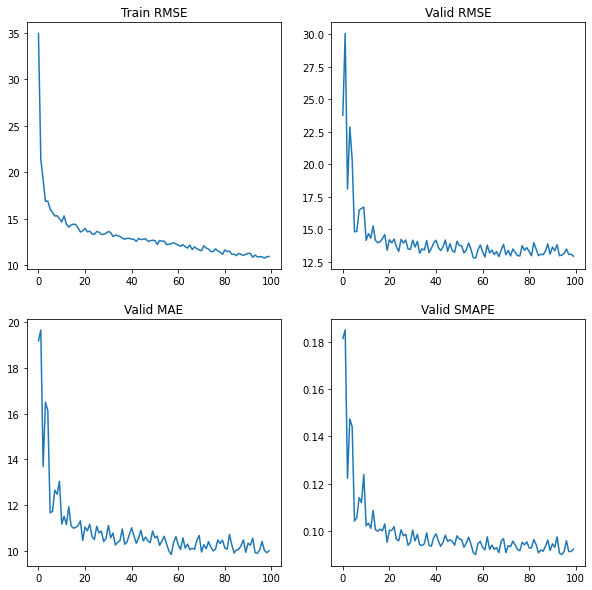

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')